In [1]:
import numpy as np 
from methods import *

In [2]:
import numpy as np 
from methods import *
# Generate transition matrices

def generate_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            if s == 0:
                # Boundary condition for state 0:
                P[n, s, 1, s + num_dummy_states] = np.random.rand()  # Stay in state 0
                P[n, s, 1, s + num_dummy_states + 1] = 1 - P[n, s, 1, s + num_dummy_states]  # Move to state 1
            elif s == num_states - 1:
                # Boundary condition for state 9 (last state):
                P[n, s, 1, s + num_dummy_states - 1] = np.random.rand()  # Move to state 8
                P[n, s, 1, s + num_dummy_states] = 1 - P[n, s, 1, s + num_dummy_states - 1]  # Stay in state 9
            else:
                # General case for non-boundary states
                P[n, s, 1, s + num_dummy_states - 1] = np.random.rand()  # Move to s-1
                P[n, s, 1, s + num_dummy_states + 1] = 1 - P[n, s, 1, s + num_dummy_states - 1]  # Move to s+1

            # Action 0: No pull, move to s+1, unless it's the last state
            if s < num_states - 1:
                P[n, s, 0, s + 1] = 1.0  # Move to s+1 with probability 1
            else:
                P[n, s, 0, s] = 1.0  # Stay in state 9 if it's the last state

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            normal_state_index = s_a - num_states
            # Copy transitions from the corresponding normal state for action 0 within dummy states
            P[n, s_a, 0, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states + num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]

    return P

In [3]:
def generate_general_transition_matrix_with_dummy_states(num_arms, num_states, num_dummy_states):
    # Initialize transition matrices
    P = np.zeros((num_arms, num_states + num_dummy_states, 2, num_states + num_dummy_states))

    for n in range(num_arms):
        # Transitions within non-dummy states (s in S)
        for s in range(num_states):
            # Action 0: Transition within S
            P[n, s, 0, :num_states] = np.random.dirichlet(np.ones(num_states))

            # Action 1: Transition to a dummy state
            P[n, s, 1, num_states:] = np.random.dirichlet(np.ones(num_dummy_states))

        # Transitions within dummy states (s in S_a)
        for s_a in range(num_states, num_states + num_dummy_states):
            # Copy transitions from the corresponding normal state for action 0
            normal_state_index = s_a - num_states
            P[n, s_a, 0, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]
            P[n, s_a, 1, num_states:num_states+num_dummy_states] = P[n, normal_state_index, 0, 0:num_states]  # Same for action 1

    return P

In [10]:
def comparison(S, N, group_member_num, K, S_prime, A, T, num_simulations = 20000, type = 'General'):
    # Define the reward function, from state 0 (reward 10) to state 9 (reward 1)
    r = np.array(list(range(S, 0, -1)) + list(range(S, 0, -1)))  # Non-dummy and dummy states have the same rewards
    # change here to generate different types of transition matrices
    P = generate_transition_matrix_with_dummy_states(N, S, S)
    P_original = P[:, :S, :, :S]+P[:,:S,:,S:]

    optimal_reward, fluid_reward, fluid_std = fluid_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    random_reward, random_std = random_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    no_pull_reward, no_pull_std =  no_pull_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    finite_whittle_reward, finite_whittle_std =  finite_whittle_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    infinite_whittle_reward, infinite_whittle_std = infinite_whittle_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)
    original_whittle_reward, original_whittle_std = original_whittle_policy(N, T, S, A, K, group_member_num, P_original, r, num_simulations)


    experiment_synthetic_result = {
        "Optimal": (optimal_reward, None),
        "fluid": (fluid_reward, fluid_std),
        "random": (random_reward, random_std),
        "no-pull": (no_pull_reward, no_pull_std),
        "finite whittle": (finite_whittle_reward, finite_whittle_std),
        "inifinite whittle": (infinite_whittle_reward, infinite_whittle_std),
        "original whittle": (original_whittle_reward, original_whittle_std)
    }
    plot_methods_with_confidence(experiment_synthetic_result, N, T, K, group_member_num, num_simulations, type)

In [4]:
np.random.seed(22)

Solver status: optimal
Optimal value: 311.4346684745032
Average total reward over 100 simulations: 908.88, stdev is 88.34657190676256
Number of pulls in dummy states (LP-based policy): 349
Average total achieved value over 100 simulations (Random policy): 846.03, stdev is 87.0740373463754
Average total achieved value over 100 simulations (No-Pull policy): 797.1, stdev is 83.35702693470982
Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Finite Whittle index policy): 931.22, stdev is 98.56286308644844
Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Infinite Whittle index policy): 927.46, stdev is 96.817376769072
Original Whittle Indices (including dummy states):
Average total achieved value over 100 simulations (General Infinite Whittle index policy): 923.4, stdev is 86.78418605653307


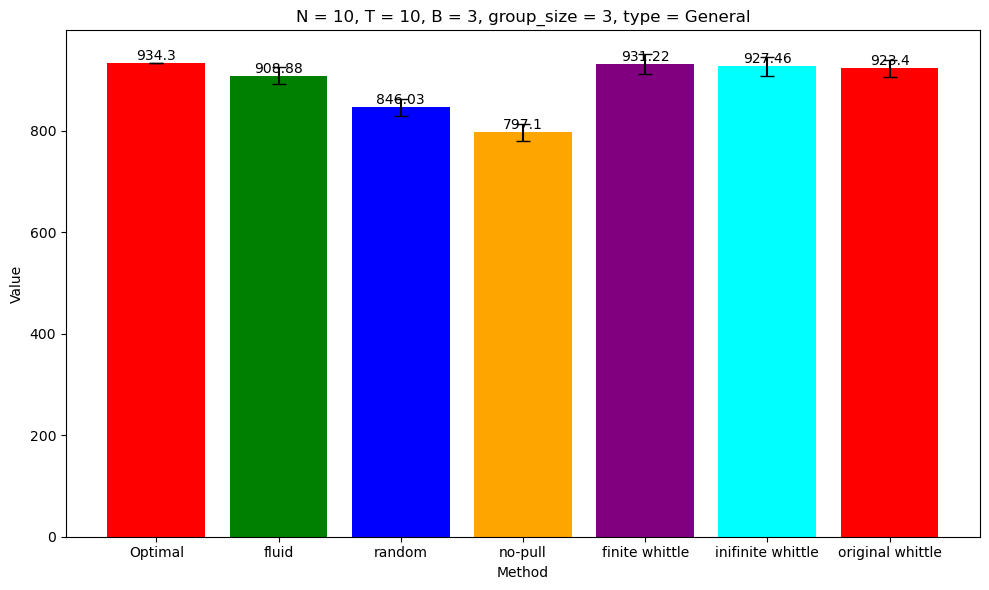

In [11]:
S = 10
N = 10
group_member_num = 3
K = 3
S_prime = S * 2
A = 2
T = 10
num_simulations = 100
comparison(S, N, group_member_num, K, S_prime, A, T, num_simulations, 'General')

In [33]:
S = 10
N = 10
group_member_num = 3
K = 3
S_prime = S * 2
A = 2
T = 10
num_simulations = 100

In [6]:
r = np.array(list(range(S, 0, -1)) + list(range(S, 0, -1)))  # Non-dummy and dummy states have the same rewards
# change here to generate different types of transition matrices
P = generate_transition_matrix_with_dummy_states(N, S, S)

In [7]:
print(r)

[10  9  8  7  6  5  4  3  2  1 10  9  8  7  6  5  4  3  2  1]


In [8]:
optimal_reward, fluid_reward, fluid_std = fluid_policy(N, T, S, S_prime, A, K, group_member_num, P, r, num_simulations)

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Solver status: optimal
Optimal value: 313.8173477333495
Average total reward over 100 simulations: 933.69, stdev is 99.06081134048087
Number of pulls in dummy states (LP-based policy): 339


In [9]:
313 * 3

939